## Matrices

### Heatmap generator

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from fw_target import U_circuit

def heatmap_matrix(M):
    matrix = np.abs(M)
    plt.figure(figsize=(5,5))
    plt.title("Heatmap of |M| (magnitude)")
    # each cell will be square because aspect='equal'
    heatmap = plt.imshow(matrix, aspect='equal')
    plt.colorbar(heatmap, label="|Mₙₘ|")
    plt.xlabel("Column index")
    plt.ylabel("Row index")
    plt.tight_layout()
    plt.show()

### Heatmap of FW circuit

In [ ]:
print("Heatmap of FW circuit:")
heatmap_matrix(U_circuit)

### Heatmaps of input states

Logical states and their density matrices:


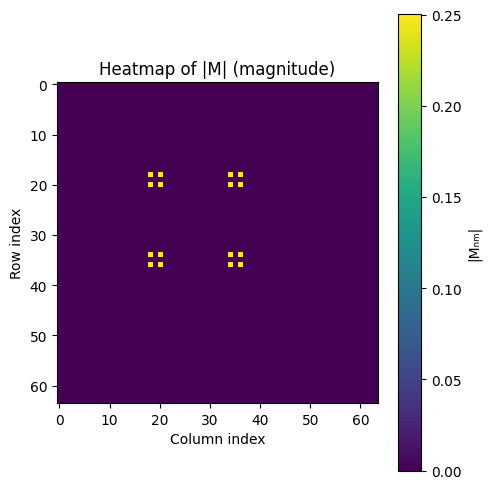

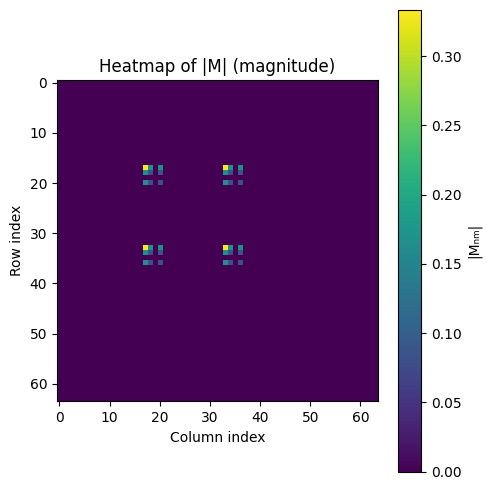

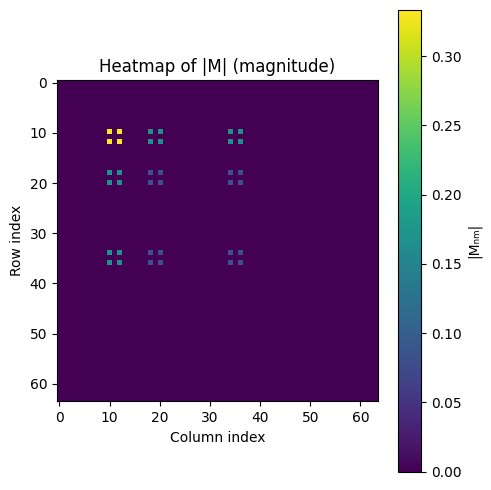

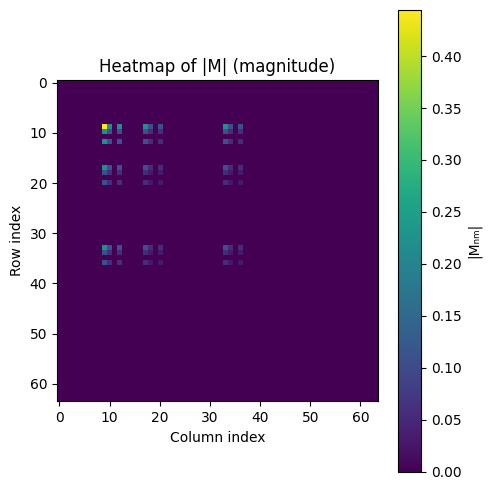

In [36]:
def state_to_density(psi):
    """
    Given a statevector psi (1D complex array),
    return the density matrix |psi><psi|.
    """
    psi = psi.reshape(-1, 1)  # make it a column vector
    return psi @ psi.conjugate().T  # outer product

def normalize_state(psi):
    """
    Ensure psi is normalized.
    """
    norm = np.linalg.norm(psi)
    if norm < 1e-15:
        raise ValueError("Zero norm state.")
    return psi / norm

logical_0_amps = np.array([0, 0, 1/np.sqrt(2), 0, -1/np.sqrt(2), 0, 0, 0], dtype=complex)
logical_1_amps = np.array([0, -np.sqrt(2/3), -1/np.sqrt(6), 0, -1/np.sqrt(6), 0, 0, 0], dtype=complex)

logical_0_H_amps = (1/np.sqrt(2))*(logical_0_amps + logical_1_amps)
logical_1_H_amps = (1/np.sqrt(2))*(logical_0_amps - logical_1_amps)

logical_0_amps = normalize_state(logical_0_amps)
logical_1_amps = normalize_state(logical_1_amps)

# Create density matrices
rho_logical_0 = state_to_density(logical_0_amps)
rho_logical_1 = state_to_density(logical_1_amps)

# logical_0_0 = rho_0 \otimes rho_0
rho_00 = np.kron(rho_logical_0, rho_logical_0)
rho_01 = np.kron(rho_logical_0, rho_logical_1)
rho_10 = np.kron(rho_logical_1, rho_logical_0)
rho_11 = np.kron(rho_logical_1, rho_logical_1)
# etc. define more as needed.

ip_arr = [rho_logical_0, rho_logical_1]
target_arr = [rho_00, rho_01, rho_10, rho_11]
print("Logical states and their density matrices:")
for i in target_arr:
    heatmap_matrix(i)

### Rearranged circuit matrix

In [43]:
def matrix_rearr(M: np.ndarray, one_based: bool = False) -> np.ndarray:
    special = [9, 10, 12, 17, 18, 20, 33, 34, 36]
    N = M.shape[0]
    if M.shape[1] != N:
        raise ValueError("Matrix must be square.")
    # convert to 0-based if needed
    if one_based:
        idx0 = [i - 1 for i in special]
    else:
        idx0 = list(special)

    # sanity check
    if any(i < 0 or i >= N for i in idx0):
        raise IndexError("One of your special indices is out of range.")

    # build the permutation: specials first, then all the rest in ascending order
    rest = [i for i in range(N) if i not in idx0]
    perm = idx0 + rest

    # now permute rows, then columns
    # (this works on any array-like, no need for np.ix_)
    M_perm = M[perm, :]   # reorder rows
    M_perm = M_perm[:, perm]  # reorder columns
    return M_perm

Rearranged matrix:


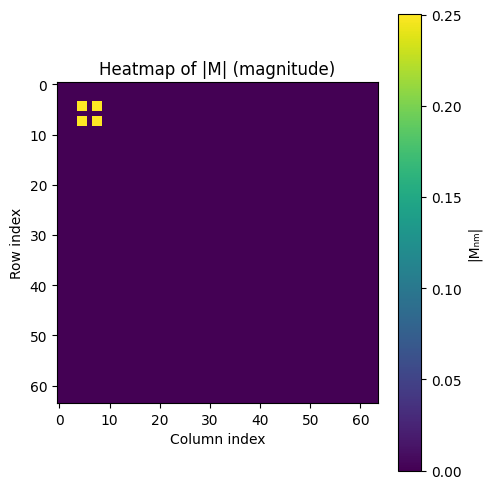

Rearranged matrix:


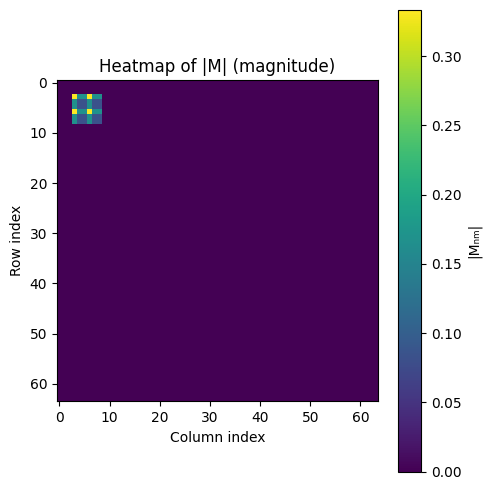

Rearranged matrix:


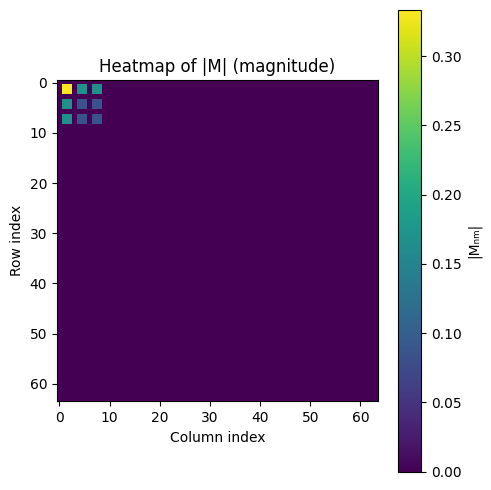

Rearranged matrix:


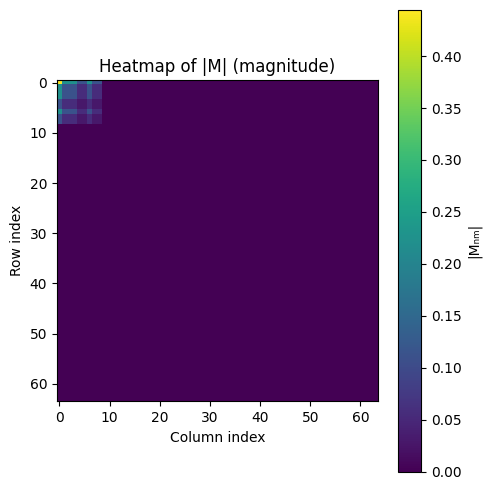

In [44]:
for i in target_arr:
    print("Rearranged matrix:")
    heatmap_matrix(matrix_rearr(i))

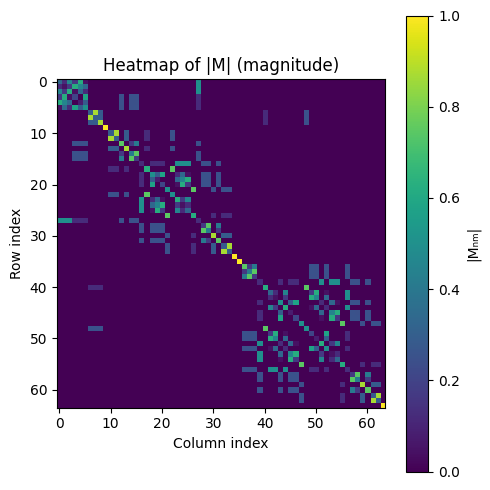

In [45]:
heatmap_matrix(matrix_rearr(U_circuit))

## To 

1. 9*64*2 blocks of U_circuit
2. Reward function:
    1. For each step if the fidelity of the 64x64 is increased , +1 to the reward.
    2. For each step if the fidelity of the 64x64 is increased by .1, +5 reward.
    3. For each step if the fidelity of the 64x64 is increased by .2, +8 reward.

    (9x9 should be replaced by 9x64x2-27)

    4. For each step if the fidelity of the 9x9 is increased, +.5 to the reward.
    5. For each step if the fidelity of the 9x9 is increased by .1, +2 reward.
    6. For each step if the fidelity of the 9x9 is increased by .2, +3 reward.
    7. If the matrix matched 27 elements of the target in the following rows and columns [9,10,12,17,18,20,33,34,36], then +30 reward.

    8. For each step if the fidelity with the target matrix is reduced compared to the previous step, then -1 reward.
    9. For each step if the fidelity with the target matrix is reduced by .1 compared to the previous step, then -2 reward.
    10. For each step if the fidelity with the target matrix is reduced by .2 compared to the previous step, then -3 reward.
    11. For each step after the 10th step, step penalty of -.25*step_count.

    12. (To add)If the matrix matches the entire 64d rows and columns of  the target matrix in the following indices [9,10,12,17,18,20,33,34,36], which would be 9*64*2 elements, +80 reward and exit.

    13. If the fidelity is greater than .99, +100 reward and exit.